In [1]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

# 7.1 투표 기반 분류기

* 더 좋은 분류기를 만드는 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것이다. 이렇게 다수결 투표로 정해지는 분류기를 직접 투표(Hard Voting) 분류기라고 한다.
* 약한 학습기(Weak Learner) : 랜덤 추측보다 조금 더 높은 성능을 내는 분류기
* 강한 학습기(Strong Learner) : 높은 정확도를 내는 분류기

* 원리
 - 예를 들어 앞면이 나올 확률이 51%이고, 뒷면이 나올 확률이 49%인 동전 던지기를 한다고 가정하자. 이러한 동전을 1,000번 던지면 약 510번은 앞면, 490번은 뒷면이 나오게 될것이다. 따라서 더 많은 횟수로 앞면이 나온다는 것을 알 수 있다. 이를 수학적으로 계산해보면 1,000번을 던진 후 앞면이 더 많이 나올 확률은 75%에 가까운 것을 알 수 있다. 동전 던지기는 이항분포이므로 다음과 같이 나타낼 수 있다.
  $$
  \binom{n}{k} p^{k}\left( 1-p \right)^{n-k}
  $$
 - 위의 식을 이용해 0~499 까지의 누적 분포 함수(CDF, Cumulative Distribution Function)를 이용해 누적 확률을 계산한 뒤, 전체 확률 1에서 빼주면 75%를 구할 수 있다. 이를 SciPy를 이용해 1-scipy.stats.binom.cdf(499, 1000, 0.51) 구할 수 있다. 또한, 동전을 10,000번 던진다면 앞면이 더 많이 나올 확률이 97%(1 - scipy.stats.binom.cdf(4999, 10000, 0.51)) 이상으로 올라간다.
 - 이와 비슷하게 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축할 경우 정확도는 75%로 기대할 수 있다. 그러나 이러한 가정은 모든 분류기가 독립적이어야 하고, 오차에 대해 상관관계가 없어야 한다.
 - 따라서, 앙상블 기법에서 독립적인 모델을 만들어 주기 위해서는 다른 머신러닝 알고리즘으로 학습시키는 것이 좋다. 그 이유는 모델 별로 다른 종류의 오차를 가지므로 상관관계가 작어지기 때문이다.

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

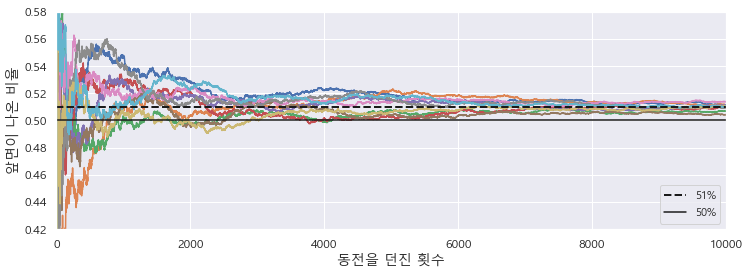

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("동전을 던진 횟수")
plt.ylabel("앞면이 나온 비율")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.888


* 간접 투표(Soft Voting) : 모든 분류기가 클래스의 확률을 예측할 수 있으면, 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있다.
* voting = "soft"로 변경하면 간접 투표 사용

In [7]:
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 7.2 배깅과 페이스팅

* 다양한 분류기를 만드는 또 다른 방법은 같은 알고리즘을 사용하고, 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것
 - 배깅(Bagging) : 훈련 세트에서 중복을 허용하여 샘플링하는 방식
 - 페이스팅(Pasting) : 중복을 허용하지 않고 샘플링 하는 방식
* 모든 예측기가 훈련을 마치면 앙상블은 통계적 최빈값을 기준으로 회귀에 대해서 평균을 계산한다.
* 각 모델은 전체 학습 데이터셋으로 학습시킨 것보다 편향되어 있지만, 앙상블을 통해 편향(bias)과 분산(variance)이 감소한다. 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비슷하지만 분산은 줄어든다.

## 7.2.1 사이컷런의 배경과 페이스팅

* 사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구성 BaggingClassifier/BaggingRegressor을 제공한다.

In [9]:
#데이터 셋
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
#결정 트리 분류기 500개의 앙상블 훈련
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred))

Accuracy = 0.92


In [11]:
#단 하나의 Decision Tree를 사용할 경우
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred_tree))

Accuracy = 0.856


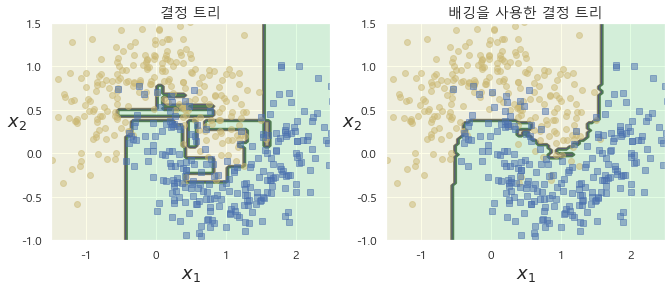

In [12]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("결정 트리", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("배깅을 사용한 결정 트리", fontsize=14)
plt.show()

# 7.2.2 obb 평가

* 배깅은 중복을 허용하는 리샘플링(Resampling), 즉 부트스트래핑(Bootstraping) 방식이기 때문에 전체 학습 데이터셋에서 어떠한 데이터 샘플은 여러번 샘플링 되고, 또 어떠한 샘플은 전혀 샘플링 되지 않을 수가 있는데, 이때 평균적으로 학습 단계에서 전체 데이터셋 중 37%가 샘플링 되지 않는데, 이 37% 데이터 샘플들을 oob(out-of-bag)샘플이라고 한다.
* 예측기가 훈련되는 동안에 oob 샘플을 사용하지 않으므로, 별도의 검증 세트를 사용하지 않고, oob 샘플을 검증세트나 교차검증에 사용할 수 있다.
* Scikit-Learn에서는 BaggingClassifier의 인자인 oob_score=True로 설정하면 학습이 끝난 후 자동으로 oob 평가를 할 수 있다.

In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
print("oob score : ", bag_clf.oob_score_)

oob score :  0.9013333333333333


In [14]:
#결정 함수 값
bag_clf.oob_decision_function_[:5]

array([[0.36312849, 0.63687151],
       [0.41358025, 0.58641975],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

# 7.3 랜덤 패치와 랜덤 서브스페이스

* BaggingClassifier는 특정 샘플링도 지원한다.
 - max_features, bootstrap_features 두 매개변수로 조절
 - 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련된다.
 - 고차원 데이터셋을 다룰 때 유용
* 랜덤 패치 방식(Random patches method) : 훈련 특성과 샘플을 모두 샘플링하는 방식
* 랜덤 서브스페이스 방식(Random subspaces method) : 훈련 샘플을 모두 사용하고 특성은 샘플링하는 방식 
 - 훈련 샘플(bootstrap=False / max_samples=1.0), 특성(bootstrap_features=True / max_samples < 1.0)
* 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다

# 7.4 랜덤 포레스트

* 랜덤 포레스트 : 배깅 방법을 적용한 결정 트리의 앙상블
 - max_samples를 훈련 세트의 크기로 지정
 - BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용

In [15]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

#BaggingClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

# 두 모델의 예측 비교
print(np.sum(y_pred == y_pred_rf) / len(y_pred))

0.984


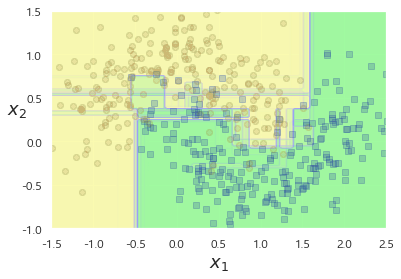

In [16]:
#시각화
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## 7.4.1 엑스트라 트리

* 익스트림 랜덤 트리(Extremely Randomized Trees) : 랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용한다. 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택하는 방법
 - 편향이 늘어나지만 대신 분산을 낮추게 된다
 - 랜덤 포레스트 처럼 각 노드의 특성마다 최적의 임계값을 찾는 것이 아니기 떄문에 엑스트라 트리가 훨씬 학습 속도가 빠르다.
 - 사이킷런에서 ExtraTreeClassifier으로 사용

In [17]:
#랜덤 포레스트와 엑스트라 트리 비교
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
extra_clf.fit(X_train, y_train)
y_pred_ext = extra_clf.predict(X_test)

# 두 모델의 예측 비교
print(np.sum(y_pred_rf == y_pred_ext) / len(y_pred_rf))

0.976


## 7.4.2 특성 중요도

* 랜덤 포레스트의 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다.
* 사이킷 런은 어떤 특성을 사사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다. 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결과값을 정규화한다.

In [18]:
#RandomForestClassifier 훈련 후 각 특성의 중요도 출력
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09457748249959061
sepal width (cm) 0.021526348361771513
petal length (cm) 0.4303507899681788
petal width (cm) 0.45354537917045906


In [19]:
#MNIST 데이터의 각 픽셀 중요도 알아보기
from tensorflow.keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

X = np.vstack((train_x, test_x))
X = X.reshape([-1, 28*28])
y = np.append(train_y, test_y)

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X, y)

RandomForestClassifier(random_state=42)

In [20]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

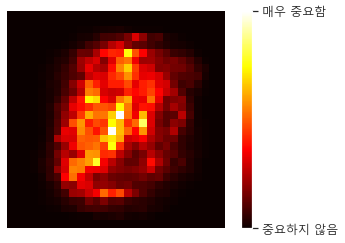

In [21]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['중요하지 않음', '매우 중요함'])

plt.show()

# 7.5 부스팅(Boosting)

* 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
* 부스팅 방법의 아이디어는 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것
* 부스팅 방법으로는 에이다부스트(AdaBoost) / 그래디언트 부스팅(Gradient Boosting)

## 7.5.1 에이다부스트

* 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것으로 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.

1. 먼저 전제 학습 데이터셋을 이용해 모델을 만둔 후, 잘못 예측된 샘플의 가중치를 상대적으로 높여준다.
2. 그 다음 두 번째 모델을 학습 시킬때 이렇게 업데이트된 가중치를 반영하여 모델을 학습 시킨다.
3. 이와 같은 과정을 반복한다.

In [23]:
#moons데이터셋에 AdaBoostClassifier 모델 학습
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 500, noise = 0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [24]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

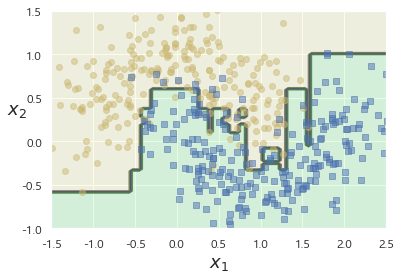

In [25]:
plot_decision_boundary(ada_clf, X, y)

### AdaBoost 알고리즘

위의 알고리즘을 각 단계별로 살펴보자.

① 먼저 각 데이터의 가중치 $w_i$는 $\frac{1}{m}$으로 초기화한다.

$t = 1, \dots, T$ 까지 반복하는데,

② 모델이 학습되고, 가중치가 적용된 에러율(weighted error rate)을 계산한다.

$$
\epsilon_t = \frac{\underset{ h_{t}(x_i) \neq y_i }{ \sum_{i=1}^{m}{w_i} } }{\sum_{i=1}^{m}{w_i}}
$$
$h_{t}(x_i)$는 $i$-번째 데이터에 대한 $t$-번째 모델의 예측값이다.
위의 식은 $t$-번째 모델에서 실제값과 예측값이 같지 않은($ h_{t}(x_i) \neq y_i$) 샘플의 가중치($w_i$)의 합에서 전체 가중치의 합으로 나눈 비율을 에러율($\epsilon_t$)라고 정의한 것이다.

③ 각 $t$-번째 모델에 대한 가중치 $\alpha_t$는 다음과 같다.

$$
\alpha_t = \eta \log{\frac{1 - \epsilon_t}{\epsilon_t}}
$$
$\eta$는 학습률(learning rate)을 의미하며, 논문에서는 학습률은 사용하지 않지만, scikit-learn의 AdaBoostClassifier에서는 learning_rate의 인자가 있으며, 기본값은 1이다.

④ 그런 다음, 아래의 식을 통해 가중치($w_i$)를 업데이트 해준다.

$$
W_{t+1} = \frac{W_t(i) \exp{\left( - \alpha_t y_i h_t \left(x_i \right) \right)}}{Z_t}
$$
$Z_t$는 정규화 인자이며, $t$-번째 모델에서 모든 데이터의 가중치를 정규화 해준다($\sum_{i=1}^{m}{w_i}$로 나눠준다).

⑤ 학습이 끝난 후 최종 결과는 $T$개의 weak learner를 weighted linear combination(가중치 선형결합)을 하여 strong learner $H(x)$를 구하여 값을 예측한다.

$$
H(\mathbf{x}) = \alpha_1 h_1(\mathbf{x}) + \cdots + \alpha_{T} h_{T}(\mathbf{x}) = \sum_{t=1}^{T}{\alpha_t h_t(\mathbf{x})}
$$
Scikit-Learn에서 AdaBoost 알고리즘
Scikit-Learn의 AdaBoostClassifier에서는 SAMME(Stagewise Additive using a Multiclass Exponential loss function)과 SAMME.R(R은 Real을 의미)이라는 Multi-Class AdaBoost를 사용(default는 algorithm='SAMME.R')한다. SAMME 알고리즘은 위의 AdaBoost 알고리즘과 거의 동일하며, $t$-번째 모델에 대한 가중치를 계산하는 부분인 ③에서의 식이 아래와 같이 다르다.

$$
\alpha_t = \eta \left( \log{\frac{1-\epsilon_t}{\epsilon_t}} + \log{(K-1)} \right)
$$
$K$는 클래스(레이블)을 의미하며 2일 경우, 즉 이진분류일 경우에는 위의 AdaBoost와 동일한 알고리즘이 된다.
SAMME.R은 각 모델의 예측값이 아닌 soft voting 처럼 예측 클래스의 확률을 이용해, $t$-번째 모델에 대한 가중치(③부분)를 계산하는 알고리즘이다.

$$
\alpha_t = -\eta \frac{K-1}{K} y \log{\hat{y}_t}
$$
$y$는 예측한 클래스와 실제 클래스가 일치(정답)할 경우에는 $1$, 그렇지 않으면 $-\frac{1}{1-K}$이다.
$\hat{y}_t$는 $t$-번째 모델이 예측한 클래스의 확률이며 식은 다음과 같다.
$$
\hat{y}(x) = \underset{k}{\text{argmax}} \sum_{t=1}^{T}{(K-1)\left( \log{\hat{y}_t} - \frac{1}{K} \sum_{k=0}^{K}{\hat{y}_t} \right)}
$$

## 7.5.2 그래디언트 부스팅

* 에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다. 이전 예측기가 만든 잔여 오차(Residual Error)에 새로운 예측기를 학습시킨다.

<img src="images/7_images/gbt.png">

In [27]:
#결정트리를 기반 예측기로 사용하는 간단한 회귀 문제
#그레이디언트 트리 부스팅(Gradient Tree Boosting) / 그레디이언트 부스티드 회귀 트리(GBRT)

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [29]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [31]:
#첫 번째 예측기에서 생긴 잔여 오차에 두번째 DecisionTreeRegressor를 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [32]:
#두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델을 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [33]:
X_new = np.array([[0.8]])  # new data

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print('y_pred :', y_pred)

y_pred : [0.75026781]


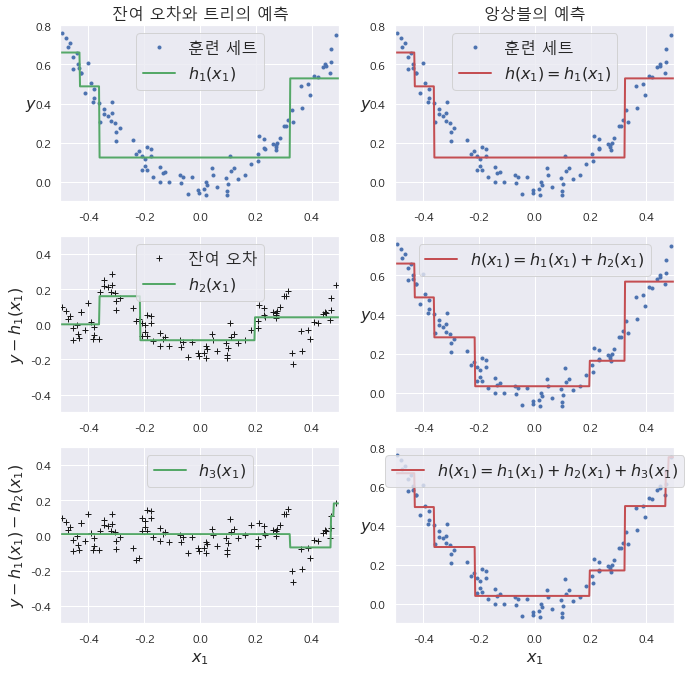

In [34]:
#시각화
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="훈련 세트")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("잔여 오차와 트리의 예측", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("앙상블의 예측", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="잔여 오차")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

### 사이킷런의 GradientBoostingRegressor

* GradientBoostingRegressor에서 learning_rate($\eta$) 인자는 학습 단계에서 각 모델(트리)의 반영 비율을 의미한다.

$$
H_t(\mathbf{x}) = H_{t-1}(\mathbf{x}) + \eta h_t(\mathbf{x})
$$

* $\eta$의 값은 $0 < \eta \le 1$이며, 값이 작을 수록 학습을 위해 더 많은 모델(트리)가 필요하지만, 성능은 좋아진다.
* 이렇게 learning_rate($\eta$)를 이용하는 방법을 축소(shrinkage)라고 하는 규제(regularization) 방법이다.

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3)

In [37]:
print('y_pred :', gbrt.predict(X_new))

y_pred : [0.75026781]


In [45]:
#GBRT를 학습시킨 후 staged_predict() 메소드를 이용해 각 모델의 예측값(y_pred)과 실제값(y_val)의
#MSE를 구한 뒤 MSE가장 낮은 최적의 트리의 개수를 찾아
#다시 최적의 트리 개수(best_n_estimator)로 그래디언트 부스팅을 학습시키는 예제
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators = bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=2)

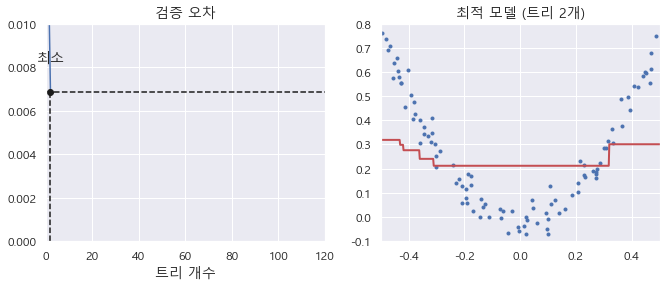

In [46]:
#시각화
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "최소", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("트리 개수")
plt.title("검증 오차", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("최적 모델 (트리 %d개)" % bst_n_estimators, fontsize=14)

plt.show()

In [52]:
#Early Stopping을 이용한 그래디언트 부스팅
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [53]:
print('최적의 트리 개수 :', gbrt.n_estimators)
print("최소 검증 MSE:", min_val_error)

최적의 트리 개수 : 100
최소 검증 MSE: 0.004058868686648048


* 확률적 그레이디언트 부스팅(Stochastic Gradient Boosting) : 각 트리를 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원.
* ex. subsample=0.25라고 하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습.
* 편향이 높아지는 대신 분산이 낮아지게 되고, 훈련 속도도 상당히 높아진다.

In [56]:
#XGBoost
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [57]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.19166
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.14404
[2]	validation_0-rmse:0.10844
[3]	validation_0-rmse:0.08579
[4]	validation_0-rmse:0.07366
[5]	validation_0-rmse:0.06767
[6]	validation_0-rmse:0.06570
[7]	validation_0-rmse:0.06491
[8]	validation_0-rmse:0.06482
[9]	validation_0-rmse:0.06529
[10]	validation_0-rmse:0.06551
Stopping. Best iteration:
[8]	validation_0-rmse:0.06482



In [58]:
xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# 7.6 스태킹

<img src="images/stacking.png">

* 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련시킬 수 없을까요? 라는 아이디어로 출발
* 앙상블 학습에서 각 모델의 예측값을 가지고 새로운 메타모델(Meta Learner)을 학습시켜 최종 예측 모델을 만드는 방법

1. 학습 데이터셋에서 샘플링을 통해 서브셋1(subset-1)을 만들고, 이 서브셋을 이용해 각 모델을 학습
2. 서브셋2(subset=2) 학습 시킨 모델을 이용해 각 모델의 예측값을 출력하고 예측값들을 합친다.
3. 합쳐진 예측값들을 입력 특성(Input feature)으로 사용하는 새로운 모델(Meta Learner, Blender)을 학습시킨다.

 - Blender을 학습시키는 일반적인 방법은 홀드 아웃(holde-out)세트를 사용하는 것이다.
 